In [2]:
from nltk import word_tokenize
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

In [129]:
dataset = pd.read_csv("reviews.txt", encoding='latin-1',  sep="\t")

In [130]:
dataset.Texto.count()

10000

# Exibe as 50 primeiras lihas

In [131]:
dataset.head(10)

,Texto,Classificador
0,Recebi bem antes do prazo estipulado.,1
1,Parabénss lojas lannister adorei comprar pela ...,1
2,aparelho eficiente. no site a marca do aparelh...,1
3,"Mas um pouco ,travando...pelo valor ta Boa.",1
4,"Vendedor confiÃ¡vel, produto ok e entrega ante...",1
5,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",0
6,PÃ©ssimo,0
7,Loja nota 10,1
8,obrigado pela atenÃ§ao amim dispensada,1
9,A compra foi realizada facilmente.,1


In [132]:
dataset.Classificador.head(50)

0     1
1     1
2     1
3     1
4     1
5     0
6     0
7     1
8     1
9     1
10    1
11    0
12    0
13    1
14    1
15    1
16    1
17    0
18    1
19    1
20    1
21    1
22    0
23    1
24    1
25    1
26    1
27    1
28    0
29    1
30    2
31    2
32    0
33    1
34    1
35    2
36    1
37    0
38    1
39    1
40    1
41    1
42    2
43    1
44    0
45    1
46    0
47    1
48    1
49    0
Name: Classificador, dtype: int64

# Conta a quantidade de linhas positivos e negativos

In [133]:
dataset[dataset.Classificador==1].count()

Texto            6426
Classificador    6426
dtype: int64

In [134]:
dataset[dataset.Classificador==0].count()

Texto            2727
Classificador    2727
dtype: int64

In [135]:
dataset[dataset.Classificador==2].count()

Texto            847
Classificador    847
dtype: int64

<AxesSubplot:>

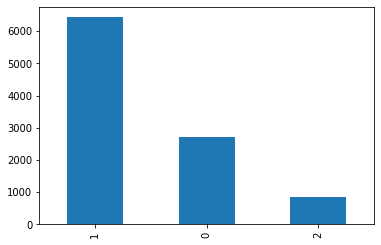

In [136]:
%matplotlib inline
dataset.Classificador.value_counts().plot(kind='bar')

# Pre-Processamento dos Dados
* Remove linhas duplicadas na base de dados
* Problema na coleta dos dados.
* Remove Stopwords
* Faz Stemming nos dados
* Remove caracteres indesejados como links, pontuação etc.

In [49]:
dataset.drop_duplicates(['Texto'], inplace=True)

In [50]:
dataset.Texto.count()

9075

# Separando comentários e suas classificações

In [51]:
comentarios = dataset['Texto']
classes = dataset['Classificador']

### Baixando base de dados

In [52]:
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to C:\Users\Gabriel
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to C:\Users\Gabriel
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

### Funções de Pre-processamento de dados

In [29]:
def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [30]:
def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [31]:
def Limpeza_dados(instancia):
    # remove links, pontos, virgulas,ponto e virgulas dos tweets
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

In [53]:
RemoveStopWords('Eu não gosto desse produto, não voltarei a comprar!')

'Eu gosto desse produto, voltarei comprar!'

In [54]:
Stemming('Eu não gosto desse produto, não voltarei a comprar!')


'eu não gost dess produto, não volt a comprar!'

In [55]:
Limpeza_dados('Olha esse produto que incrivel! :) ;)')


'olha esse produto que incrivel!  '

In [35]:
def Preprocessing(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

# Aplica a função em todos os dados:
comentarios = [Preprocessing(i) for i in comentarios]

In [56]:
Preprocessing('Eu não gosto do partido, e também não votaria novamente nesse governante. Assita o video aqui https:// :)')

'gost partido, vot nov ness govern assit vide aqu'

# Criando modelo

In [116]:
comentarios.head(10)

0                Recebi bem antes do prazo estipulado.
1    Parabénss lojas lannister adorei comprar pela ...
2    aparelho eficiente. no site a marca do aparelh...
3          Mas um pouco ,travando...pelo valor ta Boa.
4    Vendedor confiÃ¡vel, produto ok e entrega ante...
5    GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...
6                                             PÃ©ssimo
7                                         Loja nota 10
8               obrigado pela atenÃ§ao amim dispensada
9                   A compra foi realizada facilmente.
Name: Texto, dtype: object

In [114]:
comentarios[:10]

0                Recebi bem antes do prazo estipulado.
1    Parabénss lojas lannister adorei comprar pela ...
2    aparelho eficiente. no site a marca do aparelh...
3          Mas um pouco ,travando...pelo valor ta Boa.
4    Vendedor confiÃ¡vel, produto ok e entrega ante...
5    GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...
6                                             PÃ©ssimo
7                                         Loja nota 10
8               obrigado pela atenÃ§ao amim dispensada
9                   A compra foi realizada facilmente.
Name: Texto, dtype: object

In [60]:
vectorizer = CountVectorizer(analyzer="word")
''

### Aplica o vetorizador nos dados de texto

In [61]:
freq_comentarios = vectorizer.fit_transform(comentarios)
type(freq_comentarios)

scipy.sparse.csr.csr_matrix

In [62]:
modelo = MultinomialNB()
modelo.fit(freq_comentarios, classes)

MultinomialNB()

In [63]:
freq_comentarios.shape

(9075, 7132)

### Testando o modelo com algumas instancias simples

In [101]:
# defina instâncias de teste dentro de uma lista
testes = ['Esse cabo é muito bom',
          'Estou muito feliz com o produto novo',
          'Não funcionou!!!',
          'Não desejo, produto muito ruim',
          'Parece bom para se utilizar']

### Aplica a função de Pré-processamento nos dados

In [102]:
testes = [Preprocessing(i) for i in testes]

In [103]:
# Transforma os dados de teste em vetores de palavras.
freq_testes = vectorizer.transform(testes)

In [104]:
# Fazendo a classificação com o modelo treinado.
for t, c in zip (testes,modelo.predict(freq_testes)):
    print(t,c)
    #print(str(t +", "+ c))

cab bom 1
feliz produt nov 1
funcionou!!! 1
desejo, produt ruim 0
parec bom utiliz 1


In [132]:
# Probabilidades de cada classe
print(modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

[0 1 2]


array([[0.08, 0.9 , 0.02],
       [0.11, 0.88, 0.01],
       [0.4 , 0.58, 0.02],
       [0.34, 0.6 , 0.06],
       [0.08, 0.9 , 0.02]])

## Função de Tags de Negações¶
* Acrescenta uma tag _NEG encontrada após um 'não'.
* Objetivo é dar mais peso para o modelo identificar uma inversão de sentimento da frase.
* Exemplos:
*Eu gosto de cachorros, positivo.
*Eu não gosto de cachorros, negativo.

In [75]:

def marque_negacao(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

In [76]:
marque_negacao('Eu gosto desse produto, ganhei dinheiro!!!')

'eu gosto desse produto, ganhei dinheiro!!!'

In [77]:
marque_negacao('Eu Não gosto desse produto, perdi dinheiro!')


'eu não gosto_NEG desse_NEG produto,_NEG perdi_NEG dinheiro!_NEG'

# Criando modelos com Pipelines

In [118]:
from sklearn.pipeline import Pipeline

In [119]:
pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

In [120]:
pipeline_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', MultinomialNB())
])

**Treina algoritmo**

In [121]:
pipeline_simples.fit(comentarios,classes)


Pipeline(steps=[('counts', CountVectorizer()), ('classifier', MultinomialNB())])

In [122]:
pipeline_simples.steps


[('counts', CountVectorizer()), ('classifier', MultinomialNB())]

* Gera o modelo de negações


In [123]:
pipeline_negacoes.fit(comentarios,classes)


Pipeline(steps=[('counts',
                 CountVectorizer(tokenizer=<function <lambda> at 0x1BDF7B70>)),
                ('classifier', MultinomialNB())])

In [124]:
pipeline_negacoes.steps


[('counts', CountVectorizer(tokenizer=<function <lambda> at 0x1BDF7B70>)),
 ('classifier', MultinomialNB())]

# Avaliando os Modelos com Validação Cruzada

* Fazendo o cross validation do modelo


In [125]:
resultados = cross_val_predict(pipeline_simples, comentarios, classes, cv=10)


In [126]:
metrics.accuracy_score(classes,resultados)


0.8168595041322314

* Matriz confusão

In [127]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))


Predito     0     1    2   All
Real                          
0        2280   345   38  2663
1         457  5092   61  5610
2         411   350   41   802
All      3148  5787  140  9075


#  Avaliando modelo com a Tag de Negações


In [88]:
resultados = cross_val_predict(pipeline_negacoes, comentarios, classes, cv=10)


* Medindo a acurácia média do modelo


In [89]:
metrics.accuracy_score(classes,resultados)


0.7077685950413223

* Matriz confusão

In [90]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))


Predito     0     1    2   All
Real                          
0        1483  1106   74  2663
1         621  4918   71  5610
2         313   467   22   802
All      2417  6491  167  9075


# Avaliando modelo com Bigrams

In [91]:
'eu gosto', 'gosto do' , 'do brasil'


('eu gosto', 'gosto do', 'do brasil')

In [92]:
vectorizer = CountVectorizer(ngram_range=(1,2))
freq_comentarios = vectorizer.fit_transform(comentarios)
modelo = MultinomialNB()
modelo.fit(freq_comentarios,classes)

MultinomialNB()

In [93]:
resultados = cross_val_predict(modelo, freq_comentarios, classes, cv=10)


In [94]:
metrics.accuracy_score(classes,resultados)


0.8188429752066115

In [155]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))


Predito     0     1    2    All
Real                           
0        3152   945   84   4181
1        1150  6219   96   7465
2         432   343   24    799
All      4734  7507  204  12445
